In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import joblib
import keras
import matplotlib.pyplot as plt

In [86]:
TEST_DAYS = 40

In [87]:
INDICATOR_DATASET = False

In [88]:
if INDICATOR_DATASET:
    d = joblib.load('nifty_data.pkl')
else:
    d = yf.download(
                tickers="^NSEI",
                period='max',
                interval='1d',
                progress=False,
                timeout=10
            )
    d['target'] = d.Open/d.Close.shift(-1)
    d.target = d.target.apply(np.floor)

    d['change'] = abs(d['Close'].pct_change() * 100)

    d['High'] = d['High'].pct_change() * 100
    d['Low'] = d['Low'].pct_change() * 100
    d['Open'] = d['Open'].pct_change() * 100
    d['Close'] = d['Close'].pct_change() * 100 
    # d.rename(columns = {'HighNew':'High','LowNew':'Low','OpenNew':'Open','CloseNew':'Close'}, inplace = True)

    # Remove outliers when Market closes +- 3.5%
    d = d[d['change'] < 3.5]
    d.dropna(inplace=True)
    d.tail()

/var/folders/9c/8m67hqg13wd179_xl1xrnn2c0000gp/T/ipykernel_58100/1703223587.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.dropna(inplace=True)


In [103]:
def preprocessBeforeScaling(df):
    df['High'] = df['High'].pct_change() * 100
    df['Low'] = df['Low'].pct_change() * 100
    df['Open'] = df['Open'].pct_change() * 100
    df['Close'] = df['Close'].pct_change() * 100 
    return df

In [89]:
test_dataset = d.tail(TEST_DAYS)

In [90]:
d = d[:-(TEST_DAYS+1)]

In [91]:
if INDICATOR_DATASET:
    x = d.drop(columns=['target'])
    y = d.target
else:
    x = d.drop(columns=['target', 'Adj Close', 'Volume', 'change'], errors='ignore')
    y = d.target

In [92]:
x

,Open,High,Low,Close
Date,,,,
2007-09-18,-0.538904,0.060452,-0.029006,1.146926
2007-09-20,4.056922,0.461070,3.755835,0.321187
2007-09-21,0.382274,1.992293,0.265831,1.895715
2007-09-24,1.771525,1.759781,2.185388,1.956577
2007-09-25,2.107650,0.258037,0.847607,0.134826
...,...,...,...,...
2022-12-02,-0.633474,-0.559364,-0.740220,-0.618740
2022-12-05,-0.175175,-0.284047,-0.256715,0.026482
2022-12-06,-0.635167,-0.393512,-0.072341,-0.311751


In [93]:
y

Date
2007-09-18    0.0
2007-09-20    0.0
2007-09-21    0.0
2007-09-24    0.0
2007-09-25    0.0
             ... 
2022-12-02    1.0
2022-12-05    1.0
2022-12-06    1.0
2022-12-07    1.0
2022-12-08    1.0
Name: target, Length: 3632, dtype: float64

In [94]:
print('No. of Bullish samples: {}'.format(y[y == 0].size))
print('No. of Bearish samples: {}'.format(y[y == 1].size))

No. of Bullish samples: 1853
No. of Bearish samples: 1779


In [95]:
if not INDICATOR_DATASET:
    print("Using StandardScaler")
    scaler = StandardScaler()
    x = scaler.fit_transform(x.to_numpy())
    x
else:
    print("Using ColumnTransformer")
    col_names = ['Open', 'High', 'Low', 'Close', 'ATR']
    scaler = ColumnTransformer(
        [('StandardScaler', StandardScaler(), col_names)],
        remainder='passthrough'
    )
    x = scaler.fit_transform(x)
x

Using StandardScaler


array([[-0.44397101,  0.03341403, -0.07956986,  1.02006975],
       [ 2.99061278,  0.42381322,  2.99941387,  0.25208989],
       [ 0.24444976,  1.91598031,  0.16028141,  1.71648272],
       ...,
       [-0.51591104, -0.40897068, -0.11482332, -0.33657615],
       [ 0.11224095,  0.04450465, -0.27272798, -0.4569611 ],
       [-0.31388057, -0.25152816, -0.0184391 ,  0.19815053]])

In [96]:
import tensorflow as tf
from keras import Sequential
from keras import Model
from keras.layers import Dense
from keras.optimizers import SGD
import keras

lr_list = []
def scheduler(epoch, lr):
    if epoch < 15:
        lr = lr
    else:
        lr = lr * tf.math.exp(-0.01)
    lr_list.append(lr)
    return lr

units = 64 #1024
# sgd = SGD(learning_rate=0.0001, momentum=0.0, nesterov=True)
sgd = SGD(learning_rate=0.001, momentum=0.45, nesterov=True)
kernel_init = 'he_uniform'
activation = 'relu'

callback_mc = keras.callbacks.ModelCheckpoint(
                'best_model.h5',
                verbose=1,
                monitor='val_accuracy',
                save_best_only=True,
                mode='auto'
                )
callback_es = keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='auto',
                verbose=0,
                patience=200
)
callback_lr = keras.callbacks.LearningRateScheduler(scheduler)

model = Sequential([
    Dense(units, kernel_initializer=kernel_init, activation=activation, input_dim=x.shape[1]),
    # Dense(units, kernel_initializer=kernel_init, activation=activation),
    Dense(units//2, kernel_initializer=kernel_init, activation=activation),
    Dense(units//4, kernel_initializer=kernel_init, activation=activation),
    Dense(units//8, kernel_initializer=kernel_init, activation=activation),
    Dense(units//16, kernel_initializer=kernel_init, activation=activation),
    Dense(units//32, kernel_initializer=kernel_init, activation=activation),
    Dense(1, kernel_initializer=kernel_init, activation='sigmoid'),
])
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 64)                320       
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 8)                 136       
                                                                 
 dense_39 (Dense)            (None, 4)                 36        
                                                                 
 dense_40 (Dense)            (None, 2)                 10        
                                                                 
 dense_41 (Dense)            (None, 1)                

In [97]:
BATCH_SIZE = 128 #24 #4
history = model.fit(x, y, callbacks=[callback_mc, callback_es, callback_lr], batch_size=BATCH_SIZE, epochs=500, validation_split=0.15, verbose=2)

Epoch 1/500


2023-02-07 21:32:56.887556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.56514, saving model to best_model.h5
25/25 - 1s - loss: 0.7395 - accuracy: 0.5190 - val_loss: 0.6813 - val_accuracy: 0.5651 - lr: 0.0010 - 798ms/epoch - 32ms/step
Epoch 2/500


2023-02-07 21:32:57.345736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_accuracy improved from 0.56514 to 0.56881, saving model to best_model.h5
25/25 - 0s - loss: 0.7237 - accuracy: 0.5238 - val_loss: 0.6748 - val_accuracy: 0.5688 - lr: 0.0010 - 227ms/epoch - 9ms/step
Epoch 3/500

Epoch 3: val_accuracy improved from 0.56881 to 0.57064, saving model to best_model.h5
25/25 - 0s - loss: 0.7119 - accuracy: 0.5287 - val_loss: 0.6682 - val_accuracy: 0.5706 - lr: 0.0010 - 232ms/epoch - 9ms/step
Epoch 4/500

Epoch 4: val_accuracy improved from 0.57064 to 0.57798, saving model to best_model.h5
25/25 - 0s - loss: 0.7027 - accuracy: 0.5368 - val_loss: 0.6624 - val_accuracy: 0.5780 - lr: 0.0010 - 228ms/epoch - 9ms/step
Epoch 5/500

Epoch 5: val_accuracy improved from 0.57798 to 0.59266, saving model to best_model.h5
25/25 - 0s - loss: 0.6922 - accuracy: 0.5465 - val_loss: 0.6567 - val_accuracy: 0.5927 - lr: 0.0010 - 205ms/epoch - 8ms/step
Epoch 6/500

Epoch 6: val_accuracy improved from 0.59266 to 0.60734, saving model to best_model.h5
25/25 - 0s - loss

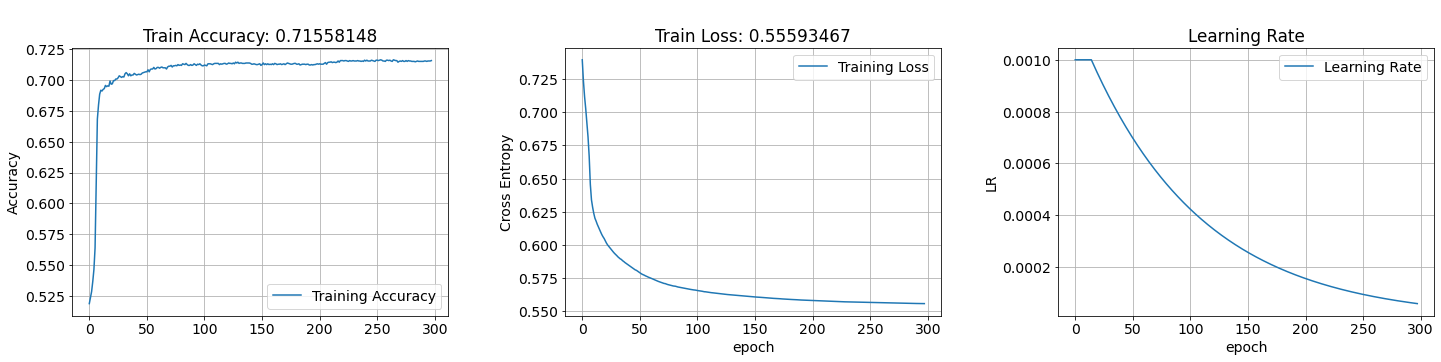

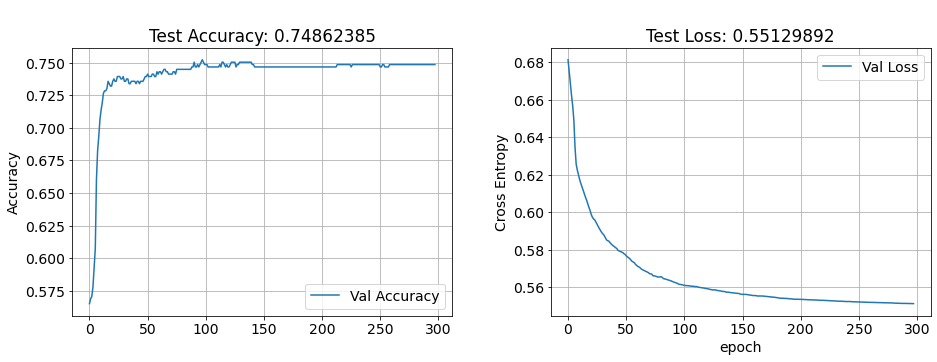

In [99]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(21,6))
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'

plt.subplot(1, 3, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTrain Accuracy: {round(acc[-1],8)}')

plt.subplot(1, 3, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'\nTrain Loss: {round(loss[-1],8)}')
plt.xlabel('epoch')

plt.subplot(1, 3, 3)
plt.plot(lr_list, label='Learning Rate')
plt.legend(loc='upper right')
plt.ylabel('LR')
plt.title(f'\nLearning Rate')
plt.xlabel('epoch')

plt.tight_layout(pad=3.0)
plt.show()

acc = history.history['val_accuracy']
loss = history.history['val_loss']

plt.figure(figsize=(14,6))
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(1, 2, 1)
plt.plot(acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTest Accuracy: {round(acc[-1],8)}')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Val Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'\nTest Loss: {round(loss[-1],8)}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

## Try Realtime Inference

In [100]:
metrics = {
    "TP": 0, "FP": 0, "TN": 0, "FN": 0
}

In [105]:
endpoint = keras.models.load_model('best_model.h5')
try:
    scaler
except NameError:
    pkl = joblib.load('nifty_model.pkl')
    scaler = pkl['scaler']
today = yf.download(
                tickers="^NSEI",
                period=f'{TEST_DAYS}d',
                interval='1d',
                progress=False,
                timeout=10
            )
today = today.drop(columns=['Adj Close', 'Volume'])

###
today = preprocessBeforeScaling(today)
###

cnt_corrct, cnt_wrong = 0, 0
for i in range(-TEST_DAYS,0):
    df = today.iloc[i]
    twr = today.iloc[i+1]['Close']
    df = scaler.transform([df])
    pred = endpoint.predict([df], verbose=0)

    if twr > today.iloc[i]['Open']:
        fact = "BULLISH"
    else:
        fact = "BEARISH"

    if pred > 0.5:
        out = "BEARISH"
    else:
        out = "BULLISH"

    if out == fact:
        cnt_correct += 1
        if out == "BULLISH":
            metrics["TP"] += 1
        else:
            metrics["TN"] += 1
    else:
        cnt_wrong += 1
        if out == "BULLISH":
            metrics["FN"] += 1
        else:
            metrics["FP"] += 1

        
    print("{} Nifty Prediction -> Market may Close {} on {}! Actual -> {}, Prediction -> {}, Pred = {}".format(
            today.iloc[i].name.strftime("%d-%m-%Y"),
            out,
            (today.iloc[i].name + pd.Timedelta(days=1)).strftime("%d-%m-%Y"),
            fact,
            "Correct" if fact == out else "Wrong",
            str(np.round(pred[0][0], 2))
            )
        )

print("Correct: {}, Wrong: {}, Accuracy: {}".format(cnt_correct, cnt_wrong, cnt_correct/(cnt_correct+cnt_wrong)))
print(metrics)

2023-02-07 21:41:16.408838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13-12-2022 Nifty Prediction -> Market may Close BEARISH on 14-12-2022! Actual -> BEARISH, Prediction -> Correct, Pred = 0.57
14-12-2022 Nifty Prediction -> Market may Close BULLISH on 15-12-2022! Actual -> BEARISH, Prediction -> Wrong, Pred = 0.4
15-12-2022 Nifty Prediction -> Market may Close BEARISH on 16-12-2022! Actual -> BEARISH, Prediction -> Correct, Pred = 0.86
16-12-2022 Nifty Prediction -> Market may Close BEARISH on 17-12-2022! Actual -> BULLISH, Prediction -> Wrong, Pred = 0.67
19-12-2022 Nifty Prediction -> Market may Close BULLISH on 20-12-2022! Actual -> BEARISH, Prediction -> Wrong, Pred = 0.35
20-12-2022 Nifty Prediction -> Market may Close BEARISH on 21-12-2022! Actual -> BEARISH, Prediction -> Correct, Pred = 0.59
21-12-2022 Nifty Prediction -> Market may Close BEARISH on 22-12-2022! Actual -> BEARISH, Prediction -> Correct, Pred = 0.8
22-12-2022 Nifty Prediction -> Market may Close BEARISH on 23-12-2022! Actual -> BEARISH, Prediction -> Correct, Pred = 0.65
23-12-20

## Save Model for Screeni-py integration

In [102]:
pkl = {
    #  'model': model,
    'scaler': scaler,
    'columns': ['Open', 'Close', 'High', 'Low']
}

joblib.dump(pkl, 'nifty_model.pkl')

['nifty_model.pkl']

In [ ]:
pkl = joblib.load('nifty_model.pkl')
z = yf.download(
                tickers="^NSEI",
                period='1d',
                interval='1d',
                progress=False,
                timeout=10
            )
z = preprocessBeforeScaling(z)
z = z.iloc[-1]
z = z[pkl['columns']]
print(z)
z = pkl['scaler'].transform([z])
endpoint.predict(z)

In [108]:
z = yf.download(
                tickers="^NSEI",
                period='5d',
                interval='1d',
                progress=False,
                timeout=10
            )
z = preprocessBeforeScaling(z)
z

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-01,NaN,NaN,NaN,NaN,17616.300781,512900
2023-02-02,-1.653417,-1.771062,0.533318,-0.033494,17610.400391,490100
2023-02-03,1.168289,1.225794,0.792448,1.383560,17854.050781,424100
2023-02-06,0.546226,-0.260777,0.649165,-0.501013,17764.599609,282500
2023-02-07,-0.159672,-0.070405,-0.258775,-0.242615,17721.500000,0


In [ ]:
pkl['model'].save('nifty_model.h5')

In [ ]:
pkl

In [ ]:
del pkl['model']

In [ ]:
pkl

In [121]:
def getSigmoidConfidence(x):
    out_min, out_max = 0, 100
    if x > 0.5:
        in_min = 0.50001
        in_max = 1
    else:
        in_min = 0
        in_max = 0.5
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

map_range(0.9633487, 0.5, 1, 0, 100)

92.66973999999999